# Welcome to BlazingSQL Notebooks!

BlazingSQL Notebooks is a fully managed, high-performance JupyterLab environment. 

**No setup required.** You just login and start writing code, immediately.

Every Notebooks environment has:   
- An attached CUDA GPU
- Pre-Installed GPU Data Science Packages ([BlazingSQL](https://github.com/BlazingDB/blazingsql), [RAPIDS](https://github.com/rapidsai), [Dask](https://github.com/dask), and many more)

Start running GPU-accelerated code below!

## The GPU DataFrame
The RAPIDS ecosystem is built on the concept of a shared GPU DataFrame, built on [Apache Arrow](http://arrow.apache.org/), between all of the different libraries and packages. This was achieved with the `cudf.DataFrame`.

There are two libraries specific to data manipulation:
- **BlazingSQL**:  SQL commands on a `cudf.DataFrame`
- **cuDF**: pandas-like commands on a `cudf.DataFrame`

### BlazingSQL (BSQL) 
[GitHub](https://github.com/BlazingDB/blazingsql) | [Intro Notebook](intro_notebooks/the_dataframe.ipynb)

BlazingSQL is a distributed SQL engine built on top of cuDF. Easily run SQL on files and DataFrames.

We start with a BlazingContext, which acts like a session of the SQL engine.

In [1]:
from blazingsql import BlazingContext
bc = BlazingContext()

BlazingContext ready


With `.create_table('table_name', 'file_path')` you can create tables from many formats. Here we infer the schema from a CSV file.

In [2]:
bc.create_table('taxi', 'data/sample_taxi.csv', header=0)

Now, we can run a SQL query directly on that CSV file with `.sql()`.

In [3]:
bc.sql('SELECT * FROM taxi')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,store_and_fwd_flag,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
0,2,2015-03-05 07:38:36,2015-03-05 07:44:06,1,1.10,-8235279.565,4975191.631,1,N,-8235303.346,4973620.602,1,6.0,0.0,0.5,2.00,0.0,8.80
1,1,2015-02-03 05:41:55,2015-02-03 05:46:54,1,0.70,-8235656.655,4972873.569,1,N,-8236483.024,4973822.361,1,5.5,0.5,0.5,1.36,0.0,8.16
2,2,2015-02-08 16:17:51,2015-02-08 16:37:45,1,3.65,-8238228.336,4974965.742,1,N,-8233503.678,4978004.758,2,16.0,0.0,0.5,0.00,0.0,16.80
3,2,2015-03-07 02:17:05,2015-03-07 02:22:18,3,0.77,-8232200.852,4980818.134,1,N,-8231245.389,4980848.420,2,5.5,0.5,0.5,0.00,0.0,6.80
4,2,2015-02-05 21:05:35,2015-02-05 21:10:33,2,0.74,-8236124.619,4973741.097,1,N,-8234966.173,4972970.518,1,5.5,0.5,0.5,1.00,0.0,7.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,2015-02-23 22:14:26,2015-02-23 22:17:34,1,0.89,-8233236.149,4978496.493,1,N,-8231928.226,4979053.300,2,5.0,0.5,0.5,0.00,0.0,6.30
999996,2,2015-01-22 03:46:03,2015-01-22 03:49:51,1,1.62,-8235466.411,4980026.247,1,N,-8234375.060,4982699.404,2,6.5,0.5,0.5,0.00,0.0,0.30
999997,2,2015-02-05 16:19:05,2015-02-05 16:38:43,2,5.20,-8234358.074,4982376.298,1,N,-8236800.662,4974834.022,1,19.5,1.0,0.5,5.32,0.0,26.62
999998,2,2015-01-27 18:29:36,2015-01-27 18:40:06,1,1.91,-8238416.031,4968924.713,1,N,-8236314.013,4971218.867,1,9.5,1.0,0.5,2.26,0.0,0.30


Learn more about [creating](https://docs.blazingdb.com/docs/creating-tables) and [querying](https://docs.blazingdb.com/docs/single-gpu) BlazingSQL tables, or the [BlazingContext API](https://docs.blazingdb.com/docs/methods-arguments).

BlazingSQL returns each query's results as a cuDF DataFrame, making for easy handoff to GPU or non-GPU solutions.

In [4]:
type(bc.sql('select * from taxi limit 10'))

cudf.core.dataframe.DataFrame

### cuDF
[GitHub](https://github.com/rapidsai/cudf) | [Intro Notebook](intro_notebooks/the_dataframe.ipynb)

cuDF is a GPU DataFrame Library similar to pandas.

In [5]:
import cudf
s = cudf.Series([3, '2', 0.01, None, 4])
s

0     3.0
1     2.0
2    0.01
3    null
4     4.0
dtype: float64

You can make a `cudf.DataFrame` from a SQL statement, each column being a `cudf.Series`.

In [6]:
df = bc.sql('select * from taxi where trip_distance < 10')

Utilize DataFrame methods like `.head()`, `.tail()`, or `.describe()`.

In [7]:
df.tail(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,store_and_fwd_flag,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
987616,2,2015-01-27 18:29:36,2015-01-27 18:40:06,1,1.91,-8238416.031,4968924.713,1,N,-8236314.013,4971218.867,1,9.5,1.0,0.5,2.26,0.0,0.3
987617,2,2015-03-01 07:19:14,2015-03-01 07:24:14,1,1.53,-8235812.077,4971424.499,1,N,-8236943.345,4973502.911,1,7.0,0.0,0.5,1.00,0.0,8.8


In [8]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
count,987618.000000,987618.000000,987618.000000,9.876180e+05,9.876180e+05,987618.000000,9.876180e+05,9.876180e+05,987618.00000,987618.000000,987618.000000,987618.000000,987618.000000,987618.000000,987618.000000
mean,1.526553,1.679614,2.053153,-8.235422e+06,4.975973e+06,1.008475,-8.235223e+06,4.976014e+06,1.37624,10.100790,0.315590,0.499046,1.341565,0.068747,8.412901
std,0.499295,1.342171,1.647690,2.239713e+03,3.165829e+03,0.456450,2.420791e+03,3.461383e+03,0.49543,6.031533,0.366221,0.024691,1.755523,0.657235,8.775337
min,1.000000,0.000000,0.000000,-8.252582e+06,4.965257e+06,1.000000,-8.253923e+06,4.965256e+06,1.00000,-150.000000,-1.000000,-0.500000,-0.750000,-26.000000,-111.050000
25%,1.000000,1.000000,0.950000,-8.236787e+06,4.973858e+06,1.000000,-8.236732e+06,4.973793e+06,1.00000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000
50%,2.000000,1.000000,1.540000,-8.235686e+06,4.976140e+06,1.000000,-8.235555e+06,4.976202e+06,1.00000,8.500000,0.000000,0.500000,1.050000,0.000000,7.800000
75%,2.000000,2.000000,2.600000,-8.234325e+06,4.978059e+06,1.000000,-8.234015e+06,4.978240e+06,2.00000,12.500000,0.500000,0.500000,2.050000,0.000000,12.800000
max,2.000000,7.000000,9.990000,-8.210381e+06,4.988766e+06,99.000000,-8.210258e+06,4.988770e+06,4.00000,1005.000000,5.500000,0.500000,495.000000,95.500000,1005.800000


You can also filter cuDF DataFrames just like pandas DataFrames.

In [9]:
df.loc[(df['passenger_count'] != 1) & (df['trip_distance'] < 10)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,store_and_fwd_flag,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
3,2,2015-03-07 02:17:05,2015-03-07 02:22:18,3,0.77,-8232200.852,4980818.134,1,N,-8231245.389,4980848.420,2,5.5,0.5,0.5,0.00,0.0,6.80
4,2,2015-02-05 21:05:35,2015-02-05 21:10:33,2,0.74,-8236124.619,4973741.097,1,N,-8234966.173,4972970.518,1,5.5,0.5,0.5,1.00,0.0,7.80
7,2,2015-02-04 23:25:27,2015-02-04 23:32:07,5,1.61,-8238354.032,4975721.343,1,N,-8236185.769,4976682.745,2,7.5,0.5,0.5,0.00,0.0,8.80
9,2,2015-01-25 14:27:24,2015-01-25 14:34:01,5,0.56,-8233618.334,4977926.822,1,N,-8234368.266,4977621.255,1,6.0,0.0,0.5,1.20,0.0,0.30
11,2,2015-02-06 23:45:47,2015-02-07 00:21:40,2,3.85,-8237552.293,4971697.934,1,N,-8236852.469,4976189.980,2,23.0,0.5,0.5,0.00,0.0,24.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987608,2,2015-01-07 08:13:59,2015-01-07 08:37:49,3,2.28,-8232027.594,4978811.060,1,N,-8234805.656,4976368.247,1,15.5,0.0,0.5,2.32,0.0,0.30
987609,2,2015-01-03 17:42:31,2015-01-03 17:53:38,2,1.36,-8236281.740,4975538.043,1,N,-8235851.994,4977687.974,2,8.5,0.0,0.5,0.00,0.0,0.30
987610,2,2015-02-28 08:29:29,2015-02-28 08:37:08,5,1.07,-8231666.642,4980123.266,1,N,-8232250.960,4981558.483,2,6.5,0.0,0.5,0.00,0.0,7.30
987611,2,2015-03-13 16:57:37,2015-03-13 16:59:39,3,0.65,-8234554.263,4980903.944,1,N,-8235198.032,4979689.770,1,4.0,1.0,0.5,1.50,0.0,7.30


To ensure interoperability, you can also easily convert from cuDF to pandas with `.to_pandas()`. This grants you access to all pandas methods, in this example, `.sample()`.

In [10]:
df.to_pandas().sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_x,pickup_y,RateCodeID,store_and_fwd_flag,dropoff_x,dropoff_y,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount
208122,1,2015-02-16 21:27:25,2015-02-16 21:31:40,1,0.60,-8235851.144,4977262.996,1,N,-8236475.380,4976519.048,2,4.5,0.5,0.5,0.00,0.0,5.80
267336,2,2015-01-03 21:39:06,2015-01-03 21:54:04,2,2.99,-8236405.737,4977044.907,1,N,-8236240.973,4972422.463,1,12.5,0.5,0.5,2.60,0.0,0.30
490821,1,2015-02-16 22:53:28,2015-02-16 22:58:21,1,0.80,-8238261.459,4974160.317,1,N,-8236987.508,4974240.464,1,5.0,0.5,0.5,1.25,0.0,7.55


Learn more about [BlazingSQL + cuDF](intro_notebooks/the_dataframe.ipynb).

## Data Visualization
cuDF DataFrames easily plug into current and GPU-accelerated visualization.


### Matplotlib

[GitHub](https://github.com/matplotlib/matplotlib) | [Intro Notebook](intro_notebooks/data_visualization.ipynb#Matplotlib)

Calling the `.to_pandas()` method, we can convert a `cudf.DataFrame` into a `pandas.DataFrame` and hand off to Matplotlib or other CPU visualization packages.

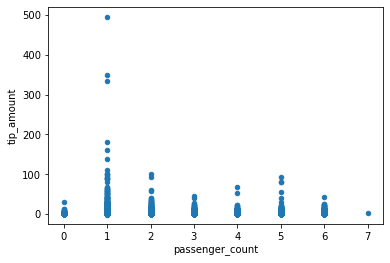

In [11]:
bc.sql('SELECT passenger_count, tip_amount FROM taxi').to_pandas().plot(kind='scatter', x='passenger_count', y='tip_amount')

### Datashader

[GitHub](https://github.com/holoviz/datashader) | [Intro Notebook](intro_notebooks/data_visualization.ipynb#Datashader)

Datashader is a data rasterization pipeline for automating the process of creating meaningful representations of large amounts of data.

Datashader is one of the first visualization tools to support GPU DataFrames, so we can directly pass in `cudf.DataFrame` query results.

In [12]:
from datashader import Canvas, transfer_functions
from colorcet import fire

We execute and pass a query as a GPU DataFrame to datashader to render taxi dropoff locations.

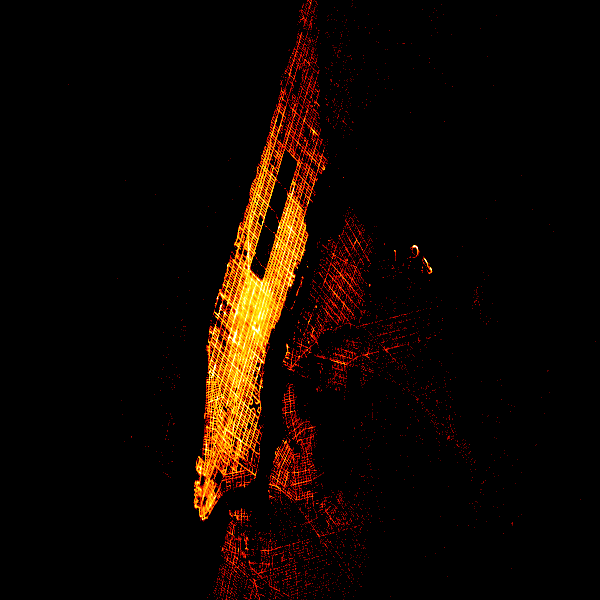

In [13]:
nyc = Canvas().points(bc.sql('SELECT dropoff_x, dropoff_y FROM taxi'), 'dropoff_x', 'dropoff_y')

transfer_functions.set_background(transfer_functions.shade(nyc, cmap=fire), "black")

## Machine Learning
### cuML 
[GitHub](https://github.com/rapidsai/cuml) | [Intro Notebook](intro_notebooks/machine_learning.ipynb)

cuML is a GPU-accelerated machine learning library similar to scikit-learn but made to run on GPU.

Let's predict fare amount of the `taxi` table we've been querying with a linear regression model.

In [14]:
%%time
from cuml import LinearRegression
from cuml.preprocessing.model_selection import train_test_split

CPU times: user 221 ms, sys: 57 µs, total: 221 ms
Wall time: 220 ms


Pull feature (X) and target (y) values

In [15]:
X = bc.sql('SELECT trip_distance, tolls_amount, pickup_x, pickup_y, dropoff_x, dropoff_y FROM taxi')
y = bc.sql('SELECT fare_amount FROM taxi')['fare_amount']

Split data into train and test sets (80:20)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Run a Linear Regression Model.

In [17]:
%%time
# call Linear Regression model
lr = LinearRegression()

# train the model
lr.fit(X_train, y_train)

# make predictions for test X values
y_pred = lr.predict(X_test)

CPU times: user 484 ms, sys: 115 ms, total: 599 ms
Wall time: 652 ms


Test the model's predicted values with sklearn's r2_score.

In [18]:
from sklearn.metrics import r2_score
r2_score(y_true=y_test.to_pandas(), y_pred=y_pred.to_pandas())

0.24910193082497667

## That is the Quick Tour!
There are in fact many more packages that are integrating the GPU DataFrame, and therefore providing interoperability with the rest of the stack.

Some of those not mentioned here are:
- **cuGraph**: a graph analytics library similar to NetworkX 
- **cuSignal**: a signal analytics library similar to SciPy Signal 
- **CLX**: a collection of cyber security use cases with the RAPIDS stack 

[Continue to The DataFrame introductory Notebook](intro_notebooks/the_dataframe.ipynb)